# Imports, classes e querys

## imports

In [478]:
import inspect
import logging
import os
import sys
from google.oauth2 import service_account
import pandas as pd
from google.cloud import bigquery
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# fix default format to display floats
pd.options.display.float_format = "{:.2f}".format

## classes

In [479]:
LOG_LEVELS = {
    "notset": logging.NOTSET,
    "debug": logging.DEBUG,
    "info": logging.INFO,
    "warning": logging.WARNING,
    "error": logging.ERROR,
    "critical": logging.CRITICAL,
}


def factory(env):
    classes_tuple = inspect.getmembers(sys.modules[__name__], inspect.isclass)
    for current_class in classes_tuple:
        if hasattr(current_class[1], "ENV"):
            if env == current_class[1].ENV:
                return current_class[1]
    return DevConfig


class BaseConfig(object):
    LOG_LEVEL = LOG_LEVELS.get(str.lower(os.environ.get("LOG_LEVEL", "info")))
    GOOGLE_CREDENTIALS_FILEPATH = "/tmp/gcloud-api.json"
    os.environ["GOOGLE_CREDENTIALS_FILEPATH"] = GOOGLE_CREDENTIALS_FILEPATH
    credentials = service_account.Credentials.from_service_account_file(GOOGLE_CREDENTIALS_FILEPATH)
    scope_credentials = credentials.with_scopes(["https://www.googleapis.com/auth/cloud-platform"])
    # GCP_REGION = "us-east1"
    # GCP_PROJECT_ID = "persono-6ab0b"


class ProdConfig(BaseConfig):
    """Production configuration."""

    ENV = "prod"


class DevConfig(BaseConfig):
    """Development configuration."""

    ENV = "dev"


config = factory(os.getenv("ENV"))

In [487]:
class DataRead:
    @classmethod
    def from_bigquery(cls, query: str) -> pd.DataFrame:
        client = bigquery.Client(project=config.credentials.project_id, credentials=config.credentials)
        dataframe = client.query(query).to_dataframe()
        return dataframe

## Querys

In [481]:
QUERY_LOJAS = """
SELECT
  *
FROM
  `projetoomni.ammo_dw.dim_lojas`
WHERE
  ativa IS TRUE
"""

In [482]:
QUERY_METAS = """
SELECT 
  EXTRACT(YEAR FROM dia) AS year,
  EXTRACT(MONTH FROM dia) AS month,
  dia AS date,
  loja,
  cpf_vendedor,
  tipo_meta,
  META as meta

FROM `projetoomni.isa_workspace.fat_metas`

WHERE EXTRACT(YEAR FROM dia) = 2024 AND
tipo_meta IN ('Meta Loja PDV', 'Meta Vendedor PDV') AND
dia <= CURRENT_DATE()  - 1
"""

In [483]:
QUERY_VENDAS_SKU = """
SELECT
  sku,
  cpf_vendedor_inteiro,
  cpf_cnpj,
  invoice_date,
  distributorId,
  type,
  parent_orderId,
  displaycode,
  priceFrom,
  priceTo,
  sellin_value,
  accounting_cost_value,
  store_cost,
  custo_cd,
  amount,
  full_value,
  gross_value,
  discount_value,
  net_value
FROM
  `projetoomni.isa_workspace.query_referencia_vendas`
WHERE
  distributorId IN ("1077", "10C5", "2585")

"""

In [484]:
QUERY_PRODUTOS = """
SELECT * FROM `projetoomni.ammo_dw.dim_produtos`
"""

In [485]:
QUERY_VENDAS = """
SELECT
  EXTRACT(YEAR FROM invoice_date) AS year,
  EXTRACT(MONTH FROM invoice_date) AS month,
  parent_orderId,
  displaycode,
  invoice_date,
  distributorId,
  groupCode,
  distributorId_ajustado,
  tipo_transacao,
  vendedor,
  cupom_vendedor,
  cpf_vendedor_inteiro,  
  SUM(priceFrom) AS priceFrom,
  SUM(priceTo) AS priceTo, 
  SUM(sellin_value) AS sellin_value, 
  SUM(accounting_cost_value) AS accounting_cost_value, 
  SUM(store_cost) AS store_cost, 
  SUM(custo_cd) AS custo_cd, 
  SUM(amount) AS amount, 
  SUM(full_value) AS full_value, 
  SUM(gross_value) AS gross_value, 
  SUM(discount_value) AS discount_value, 
  SUM(net_value) AS net_value
FROM `projetoomni.isa_workspace.query_referencia_vendas`
WHERE EXTRACT(YEAR FROM invoice_date) = 2024
GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12
"""

In [486]:
QUERY_VENDEDORES = """
SELECT * FROM `projetoomni.isa_workspace.DIM_VENDEDOR`
WHERE ativo = 'Ativo'
"""

In [496]:
print("DataRead.from_bigquery(QUERY_VENDAS_SKU) - INICIO")
df_vendas_sku = DataRead.from_bigquery(QUERY_VENDAS_SKU)

print("DataRead.from_bigquery(QUERY_PRODUTOS) - INICIO")
df_produtos = DataRead.from_bigquery(QUERY_PRODUTOS)

print("DataRead.from_bigquery(QUERY_LOJAS) - INICIO")
df_lojas = DataRead.from_bigquery(QUERY_LOJAS)

print("DataRead.from_bigquery(QUERY_METAS) - INICIO")
df_metas_completo = DataRead.from_bigquery(QUERY_METAS)

print("DataRead.from_bigquery(QUERY_VENDAS) - INICIO")
df_vendas = DataRead.from_bigquery(QUERY_VENDAS)

print("DataRead.from_bigquery(QUERY_VENDEDORES) - INICIO")
df_vendedores = DataRead.from_bigquery(QUERY_VENDEDORES)

DataRead.from_bigquery(QUERY_VENDAS_SKU) - INICIO
DataRead.from_bigquery(QUERY_PRODUTOS) - INICIO
DataRead.from_bigquery(QUERY_LOJAS) - INICIO
DataRead.from_bigquery(QUERY_METAS) - INICIO


/Users/administrador/Library/Caches/pypoetry/virtualenvs/analytics-api-ucxJW2hc-py3.10/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


DataRead.from_bigquery(QUERY_VENDAS) - INICIO
DataRead.from_bigquery(QUERY_VENDEDORES) - INICIO


## Limpeza e ajustes dos dados

- df_metas

In [499]:
mask_meta_zero = df_metas_completo["meta"] == 0
df_metas_completo[mask_meta_zero]
df_metas_completo.loc[mask_meta_zero, "meta"] = np.nan
df_metas_completo.sample(10)

,year,month,date,loja,cpf_vendedor,tipo_meta,meta
7192,2024,1,2024-01-26,0724,26705574810,Meta Vendedor PDV,994.50
22654,2024,1,2024-01-24,1099,None,Meta Loja PDV,11682.00
236855,2024,6,2024-06-22,1060,05785177102,Meta Vendedor PDV,3650.25
134938,2024,4,2024-04-04,0713,None,Meta Loja PDV,9045.00
236747,2024,6,2024-06-27,10C2,26510575841,Meta Vendedor PDV,1525.25
178117,2024,5,2024-05-10,0769,14220470751,Meta Vendedor PDV,NaN
89653,2024,3,2024-03-02,1093,None,Meta Loja PDV,9044.00
128841,2024,4,2024-04-07,0768,87235501987,Meta Vendedor PDV,NaN
325643,2024,8,2024-08-14,0735,None,Meta Loja PDV,NaN
302919,2024,8,2024-08-25,1039,None,Meta Loja PDV,NaN


In [502]:
df_metas_ajustado = df_metas_completo.copy()
df_metas_ajustado.dropna(subset=["loja", "meta"], inplace=True)
df_metas_ajustado.sample(10)

,year,month,date,loja,cpf_vendedor,tipo_meta,meta
245942,2024,6,2024-06-27,2585,15789744885,Meta Vendedor PDV,751.00
231785,2024,6,2024-06-16,2575,01771386371,Meta Vendedor PDV,710.00
280955,2024,7,2024-07-03,2555,00865564361,Meta Vendedor PDV,579.75
7660,2024,1,2024-01-04,0559,None,Meta Loja PDV,5064.00
262442,2024,7,2024-07-27,0753,02442781999,Meta Vendedor PDV,911.20
100898,2024,3,2024-03-20,10F8,70898766753,Meta Vendedor PDV,909.40
98547,2024,3,2024-03-09,2586,01465706690,Meta Vendedor PDV,748.75
68708,2024,2,2024-02-08,0668,None,Meta Loja PDV,5327.00
232955,2024,6,2024-06-10,2538,78468485187,Meta Vendedor PDV,1053.00
291583,2024,8,2024-08-11,10L7,28776880893,Meta Vendedor PDV,1860.33


# df_EDAs

## df_metas

In [503]:
df_metas_ajustado.head()

,year,month,date,loja,cpf_vendedor,tipo_meta,meta
6,2024,9,2024-09-01,1089,None,Meta Loja PDV,9157.00
9,2024,9,2024-09-01,2510,None,Meta Loja PDV,6641.00
10,2024,9,2024-09-01,0666,None,Meta Loja PDV,2676.00
11,2024,9,2024-09-01,2524,None,Meta Loja PDV,3304.00
12,2024,9,2024-09-01,2558,None,Meta Loja PDV,6026.00


In [490]:
df_metas_ajustado["tipo_meta"].unique()

array(['Meta Loja PDV', 'Meta Vendedor PDV'], dtype=object)

In [504]:
meta_loja_mask = df_metas_ajustado["tipo_meta"] == "Meta Loja PDV"
group_col = ["year", "month", "loja"]
df_metas_ajustado.groupby(group_col)["meta"].sum().reset_index()

,year,month,loja,meta
0,2024,1,0502,1400464.33
1,2024,1,0505,724740.71
2,2024,1,0509,581482.67
3,2024,1,0514,1127520.00
4,2024,1,0529,136790.00
...,...,...,...,...
2120,2024,9,2584,2553.00
2121,2024,9,2586,3524.00
2122,2024,9,2588,1729.00
2123,2024,9,3001,9028.00


In [505]:
df_metas_ajustado[meta_loja_mask].groupby(group_col)["meta"].sum().reset_index()

,year,month,loja,meta
0,2024,1,0502,600199.00
1,2024,1,0505,390245.00
2,2024,1,0509,218056.00
3,2024,1,0514,563760.00
4,2024,1,0529,68395.00
...,...,...,...,...
2120,2024,9,2584,2553.00
2121,2024,9,2586,3524.00
2122,2024,9,2588,1729.00
2123,2024,9,3001,9028.00


In [509]:
# group_col -> -> ['year', 'month', 'loja']
df_metas_agrupado_por_loja = df_metas_ajustado[meta_loja_mask].groupby(group_col)["meta"].sum().reset_index()
df_metas_agrupado_por_loja

,year,month,loja,meta
0,2024,1,0502,600199.00
1,2024,1,0505,390245.00
2,2024,1,0509,218056.00
3,2024,1,0514,563760.00
4,2024,1,0529,68395.00
...,...,...,...,...
2120,2024,9,2584,2553.00
2121,2024,9,2586,3524.00
2122,2024,9,2588,1729.00
2123,2024,9,3001,9028.00


In [510]:
df_metas_agrupado_por_loja.describe()

,year,month,meta
count,2125.00,2125.00,2125.00
mean,2024.00,4.75,145613.55
std,0.00,2.50,191414.82
min,2024.00,1.00,-24027.00
25%,2024.00,3.00,70757.00
50%,2024.00,5.00,113166.00
75%,2024.00,7.00,175821.00
max,2024.00,9.00,4195815.00


## df_vendas

In [122]:
df_vendas.head()

,year,month,parent_orderId,displaycode,invoice_date,distributorId,groupCode,distributorId_ajustado,tipo_transacao,vendedor,...,priceTo,sellin_value,accounting_cost_value,store_cost,custo_cd,amount,full_value,gross_value,discount_value,net_value
0,2024,3,24f71201-7a9b-4365-8410-abc181fb6193,24f71201-7a9b-4365-8410-abc181fb6193,2024-03-05,0765,0512,0765,STORE,MARIA PEREIRA,...,239.70,66.27,NaN,66.27,54.17,3,239.70,239.70,0.00,239.70
1,2024,5,60669948-6b2d-4321-8ef3-3c61bb9a8d57,60669948-6b2d-4321-8ef3-3c61bb9a8d57,2024-05-17,0633,0538,0633,STORE,PAULA BRAGA,...,659.80,455.56,NaN,455.56,326.01,2,958.00,659.80,0.00,659.80
2,2024,7,bbd1a6f4-8270-4371-b9b4-d9036883574e,bbd1a6f4-8270-4371-b9b4-d9036883574e,2024-07-02,0729,0553,0729,STORE,GIOVANA CHAVES,...,1269.30,494.34,NaN,494.34,344.72,7,1427.50,1269.30,24.98,1244.32
3,2024,4,02823fcf-5fe7-4e45-9d07-377f83737318,02823fcf-5fe7-4e45-9d07-377f83737318,2024-04-07,0724,0572,0724,STORE,AURICELIA KLEIN,...,459.80,252.21,NaN,252.21,103.36,3,689.70,689.70,68.97,620.73
4,2024,1,bfedcafb-c3aa-4793-a6f3-590b61f7fa22,bfedcafb-c3aa-4793-a6f3-590b61f7fa22,2024-01-20,0574,0574,0574,STORE,EVELLYN SANTOS,...,429.80,219.27,NaN,219.27,101.39,3,629.70,629.70,31.49,598.21


In [123]:
df_vendas.columns

Index(['year', 'month', 'parent_orderId', 'displaycode', 'invoice_date',
       'distributorId', 'groupCode', 'distributorId_ajustado',
       'tipo_transacao', 'vendedor', 'cupom_vendedor', 'cpf_vendedor_inteiro',
       'priceFrom', 'priceTo', 'sellin_value', 'accounting_cost_value',
       'store_cost', 'custo_cd', 'amount', 'full_value', 'gross_value',
       'discount_value', 'net_value'],
      dtype='object')

## df_vendas_sku

In [124]:
df_vendas_sku.head()

,sku,cpf_vendedor_inteiro,cpf_cnpj,invoice_date,distributorId,type,parent_orderId,displaycode,priceFrom,priceTo,sellin_value,accounting_cost_value,store_cost,custo_cd,amount,full_value,gross_value,discount_value,net_value
0,KKN28.GBLO21MR,27538565833,08750595890,2022-09-29,1077,Propria,4138d41d-6121-45c3-ace4-df9582ca06b7,4138d41d-6121-45c3-ace4-df9582ca06b7,3290.00,3290.00,NaN,563.10,563.10,563.11,1,3290.00,3290.00,0.00,3290.00
1,DIFUN.RGOO20RO,27538565833,02803481936,2023-03-13,1077,Propria,d0995792-ca21-4747-8e73-934b43e4c65a,d0995792-ca21-4747-8e73-934b43e4c65a,159.00,159.00,44.10,29.36,29.36,25.47,1,159.00,159.00,6.19,152.81
2,KKN2S.ESSO11BC,91607450372,76474194120,2023-04-18,1077,Propria,973efe19-5ea5-4d96-bb9c-a773bd00847a,973efe19-5ea5-4d96-bb9c-a773bd00847a,2990.00,2990.00,1025.96,594.36,594.36,594.36,1,2990.00,2990.00,2990.00,0.00
3,CASRE.BAMT15VD,65569040587,43809422878,2023-03-01,10C5,Outlet,8EX7LRV96,8EX7LRV96-1,59.00,59.00,19.05,13.93,13.93,14.01,1,59.00,59.00,2.95,56.05
4,KQN2H.PPRO19AC4,26954430803,15044850845,2024-04-27,10C5,Outlet,15f57312-a021-40a7-87c5-a96d5357e67c,15f57312-a021-40a7-87c5-a96d5357e67c,2690.00,1234.50,NaN,218.99,218.99,NaN,1,2690.00,1234.50,61.71,1172.79


In [125]:
df_vendas_sku.columns

Index(['sku', 'cpf_vendedor_inteiro', 'cpf_cnpj', 'invoice_date',
       'distributorId', 'type', 'parent_orderId', 'displaycode', 'priceFrom',
       'priceTo', 'sellin_value', 'accounting_cost_value', 'store_cost',
       'custo_cd', 'amount', 'full_value', 'gross_value', 'discount_value',
       'net_value'],
      dtype='object')

## df_produtos

In [126]:
df_produtos.head()

,sku,ean,rede,marca,departamento,grupo,grupo_planejamento,segmento,macro_categoria,categoria,...,segmento_ecom,categoria_ecom,linha_ecom,colecao_ecom,titulo_ecom,descritivo_ecom,palavra_chave_ecom,macro_categoria_ecom,estoque_cd,isBundle
0,VKN3EB,0,None,MM,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,False,<NA>
1,XMT1002,0,None,AR,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,False,<NA>
2,XMT1170,0,None,AR,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,False,<NA>
3,XMT1245,0,None,AR,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,False,<NA>
4,XMT1453,0,None,AR,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,False,<NA>


In [511]:
df_produtos.columns

Index(['sku', 'ean', 'rede', 'marca', 'departamento', 'grupo',
       'grupo_planejamento', 'segmento', 'macro_categoria', 'categoria',
       'familia', 'estampa', 'cor', 'cor_base', 'cor_coteminas', 'tamanho',
       'descricao', 'tipo', 'tinto', 'pais_origem', 'tipo_linha',
       'tipo_linha_gsm', 'peso_liquido', 'procedencia', 'classificacao_totvs',
       'ativo_backoffice', 'sku_CM7', 'sku_CM3', 'sku_J01', 'sku_WM1',
       'colecao', 'unidade_medida', 'codigo_interno', 'ksys_ficha_tecnica',
       'data_venda_inicial', 'data_venda_final', 'codigo_origem',
       'classificacao_codigo_origem', 'grupo_loja', 'descricao_grupo_loja',
       'numero_classificacao_fiscal', 'id_pantone', 'tipo_tecido',
       'numero_pecas', 'markup_franquia', 'markup_propria', 'preco_de_ecom',
       'preco_para_ecom', 'custo_atual', 'sellin_atual', 'ativo_ecom',
       'disponivel_bko', 'foto_still_ecom', 'foto_semi_ecom',
       'foto_detalhe_ecom', 'grupo_ecom', 'insumo', 'segmento_ecom',
       '

In [513]:
df_produtos["departamento"]
df_produtos["segmento"]
df_produtos["grupo_planejamento"].unique()

array([None, 'LENCOIS', 'INSUMOS', 'INSTITUCIONAL', 'BANHO', 'COBERTURAS',
       'UD', 'MESA', 'CORTINAS', 'ACESSORIOS PARA CAMA',
       'TRAVESSEIROS E ENCHIMENTOS', 'FRETE', 'TAPETES',
       'MOVEIS E COLCHOES', 'SLEEP WEAR', 'BRINDES', 'PET',
       'PERFUMARIA E AROMAS', 'CAMA'], dtype=object)

In [514]:
df_vendas_detalhes = df_vendas_sku.merge(df_produtos, on="sku", how="left")
df_vendas_detalhes.head()

,sku,cpf_vendedor_inteiro,cpf_cnpj,invoice_date,distributorId,type,parent_orderId,displaycode,priceFrom,priceTo,...,segmento_ecom,categoria_ecom,linha_ecom,colecao_ecom,titulo_ecom,descritivo_ecom,palavra_chave_ecom,macro_categoria_ecom,estoque_cd,isBundle
0,N8PTI.IMPT20BC,91607450372,38892055852,2023-03-04,1077,Propria,f37eac3f-3ae1-4feb-a414-a487985bc35d,f37eac3f-3ae1-4feb-a414-a487985bc35d,159.00,159.00,...,CAMA,PROTETOR DE TRAVESSEIRO,IMPERMEAVEL,None,Protetor de Travesseiro Impermeável Standard,O Protetor de Travesseiro Standard deixa seus ...,"Protetor de Travesseiro, impermeável, 65% poli...",PROTETOR DE TRAVESSEIRO,False,False
1,DKN4H.DOPP22MR,91607450372,23433082847,2023-07-11,1077,Propria,G62JKV596,G62JKV596-2,1899.00,1499.00,...,CAMA,CAPA DE EDREDOM,DOPPIO,None,Kit Capa de Edredom Acetinado Supreme Bordado ...,Aconchego nos mínimos detalhes. O Kit Capa de ...,capa de edredom; kit capa de edredom; duvet; c...,CAPA DE EDREDOM,True,False
2,ENQ50.CONT20BC,02377571336,30233923829,2022-07-07,1077,Propria,fe176671-6acf-4776-9266-ad4398db1b64,fe176671-6acf-4776-9266-ad4398db1b64,75.00,75.00,...,CAMA,ENCHIMENTO,CONFORTO,None,Enchimento para Almofada Conforto,O Enchimento para Almofada Conforto é perfeito...,"enchimento almofada, enchimento de almofada, e...",ENCHIMENTO,True,False
3,TM32R.NATV17BC2,25597185888,16980511823,2022-04-30,10C5,Outlet,1dd3f0de-e2ac-44fd-bb5a-d7304cd35f9f,1dd3f0de-e2ac-44fd-bb5a-d7304cd35f9f,541.50,170.50,...,MESA TEXTIL,TOALHA DE MESA,None,None,LEVES DEFEITOS TOALHA DE MESA RENDA,None,None,MESA,False,False
4,CAPAC.FLNP22VE,25597185888,36976655883,2021-11-23,10C5,Outlet,66bce7c3-0d6b-42a9-86eb-54fdecac1a32,66bce7c3-0d6b-42a9-86eb-54fdecac1a32,94.50,94.50,...,DECORACAO,CAPACHO,FELIZ NATAL,None,Capacho em Fibra de Coco Feliz Natal,Para tornar a decoração natalina completa e ch...,"capacho, tapete capacho, capacho natalino, cap...",CAPACHO,False,False


In [522]:
df_vendas_detalhes_agrupado = df_vendas_detalhes.groupby(["distributorId", "segmento"])["net_value"].sum().reset_index()
df_vendas_detalhes_agrupado.head()

,distributorId,segmento,net_value
0,1077,ACESSORIOS,3939.76
1,1077,AROMAS,220751.96
2,1077,BANHO,466451.75
3,1077,CAMA,5094788.27
4,1077,COZINHA,3458.63


- Apresentando o total de vendas de acordo com o segmento

<Axes: title={'center': 'Total vendas por segmento em todas as lojas - segmentos secundários agrupados'}, xlabel='net_value', ylabel='segmento'>

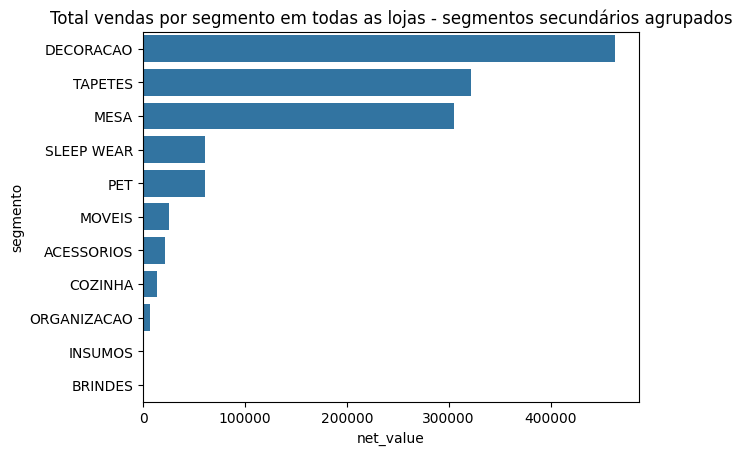

In [579]:
df_total_vendas_segmento = df_vendas_detalhes.groupby(["segmento"])["net_value"].sum().reset_index()
df_total_vendas_segmento.sort_values(by="net_value", ascending=False, inplace=True)

set_segmentos_secundarios_agrupados = {
    "SLEEP WEAR",
    "PET",
    "MOVEIS",
    "ACESSORIOS",
    "COZINHA",
    "ORGANIZACAO",
    "INSUMOS",
    "BRINDES",
    "DECORACAO",
    "TAPETES",
    "MESA",
}
mask_segmentos_secundarios_agrupados = df_total_vendas_segmento["segmento"].isin(set_segmentos_secundarios_agrupados)
mask_frete = df_total_vendas_segmento["segmento"] == "FRETE"

plt.title("Total vendas por segmento em todas as lojas - segmentos secundários agrupados")
sns.barplot(data=df_total_vendas_segmento[mask_segmentos_secundarios_agrupados], x="net_value", y="segmento")

<Axes: title={'center': 'Total vendas por segmento em todas as lojas - segmentos primários agrupados'}, xlabel='net_value', ylabel='segmento'>

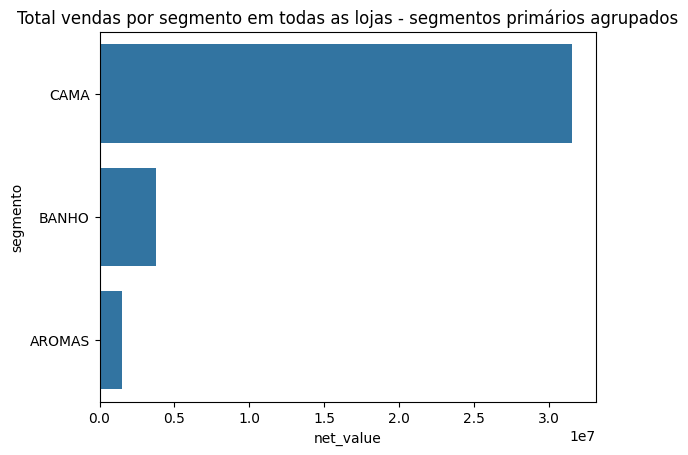

In [580]:
plt.title("Total vendas por segmento em todas as lojas - segmentos primários agrupados")
sns.barplot(
    data=df_total_vendas_segmento[~mask_segmentos_secundarios_agrupados & ~mask_frete], x="net_value", y="segmento"
)

<Axes: title={'center': 'Total vendas por segmento loja 1077'}, xlabel='net_value', ylabel='segmento'>

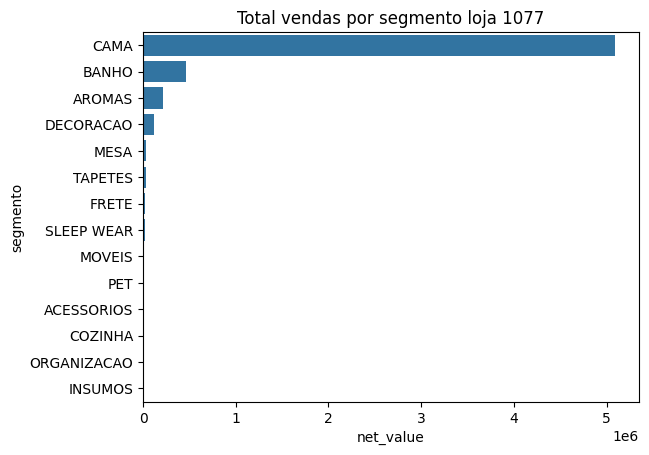

In [582]:
mask_distibuitorId = df_vendas_detalhes_agrupado["distributorId"] == "1077"

df_vendas_segmento_por_loja = df_vendas_detalhes_agrupado[mask_distibuitorId]
df_vendas_segmento_por_loja = df_vendas_segmento_por_loja.sort_values(by="net_value", ascending=False)
df_vendas_segmento_por_loja
plt.title("Total vendas por segmento loja 1077")
sns.barplot(data=df_vendas_segmento_por_loja, x="net_value", y="segmento")

# segmento_list = ['AROMAS', 'BANHO', 'CAMA']
# segmento_mask = df_vendas_detalhes['segmento'].isin(segmento_list)
# df_vendas_detalhes[mask_distibuitorId & segmento_mask].groupby(['distributorId', 'segmento'])['net_value'].sum().reset_index().set_index('segmento').plot(kind='barh')

/var/folders/n1/xxg8_mbs5y3_lz10vcxzptc80000gn/T/ipykernel_12174/1688211076.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.barplot(data=df_vendas_segmento_por_loja[~mask_segmentos_secundarios_agrupados], x='net_value', y='segmento')


<Axes: title={'center': 'Total vendas por segmento loja 1077 - produtos secundários'}, xlabel='net_value', ylabel='segmento'>

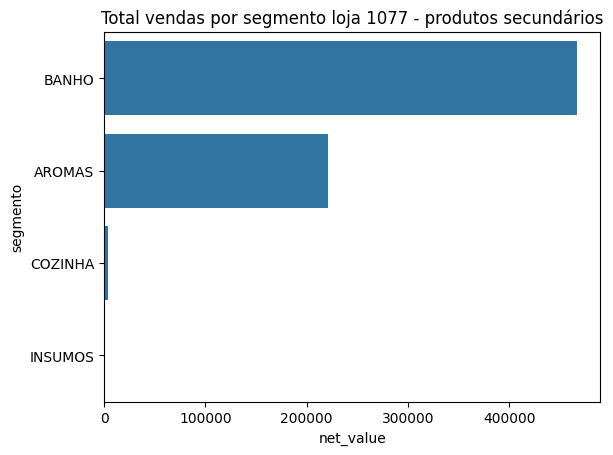

In [587]:
plt.title("Total vendas por segmento loja 1077 - produtos secundários")
sns.barplot(data=df_vendas_segmento_por_loja[~mask_segmentos_secundarios_agrupados], x="net_value", y="segmento")

In [136]:
"1077", "10C5", "2585"

('1077', '10C5', '2585')

# desafio

- "1077", "10C5", "2585"
- 'AROMAS', 'BANHO', 'CAMA', 'OUTROS'

Media de segmento por atendimento de cada vendedor

- tabela final =
 
| Nome do vendedor | cpf do vendedor | id da loja | mes | ano | quantos atendimentos no mes | valor (vendas) total dos atendimentos no mes | media de qtde segmento por atendimento |




- Construir um df/tabela acima com as colunas
- Criar coluna mes e ano
- Criar coluna qtde atendimentos no mes
- Criar coluna valor total dos atendimentos no mes
- Criar coluna média de segmentos por atendimento
- Agrupar de acordo com as medidas

-------------

- Substituir os valores de segmento que não queremos por - OUTROS
- Encontrar quantos itens foram vendidos por atendimento
- Agregar os segmentos de um atendimento em um set

In [207]:
lista_segmentos = ["AROMAS", "AROMAS", "CAMA"]
len(lista_segmentos)

3

In [208]:
set_segmentos_a = {"AROMAS", "AROMAS", "CAMA"}
set_segmentos_a
len(set_segmentos_a)

2

In [201]:
set_segmentos_b = {"BANHO", "CAMA"}
set_segmentos_b

{'BANHO', 'CAMA'}

In [206]:
set_segmentos_c = {"BANHO"}
set_segmentos_c.issubset(set_segmentos_b)

True

In [133]:
df_vendedores.head()

,cpf,name,employeePositionId,Cadastro,cargo,ativo,Desligamento
0,37235653876,Pedro de Oliveira,28,NaT,GERENTE DE LOJA,Ativo,NaT
1,31682467864,Eduardo Nardi,28,NaT,GERENTE DE LOJA,Ativo,NaT
2,04913909398,Jackson Miranda,28,NaT,GERENTE DE LOJA,Ativo,NaT
3,45681862852,Didimo Nanine,147,NaT,VENDEDOR (A),Ativo,NaT
4,04159646603,ANDREIA ANDRADE BARCELOS,28,2019-10-07,GERENTE DE LOJA,Ativo,NaT


In [134]:
df_vendas_detalhes.head()
# pd.to_datetime(df_vendas_detalhes['invoice_date'])

,sku,cpf_vendedor_inteiro,cpf_cnpj,invoice_date,distributorId,type,parent_orderId,displaycode,priceFrom,priceTo,...,segmento_ecom,categoria_ecom,linha_ecom,colecao_ecom,titulo_ecom,descritivo_ecom,palavra_chave_ecom,macro_categoria_ecom,estoque_cd,isBundle
0,KKN28.GBLO21MR,27538565833,08750595890,2022-09-29,1077,Propria,4138d41d-6121-45c3-ace4-df9582ca06b7,4138d41d-6121-45c3-ace4-df9582ca06b7,3290.00,3290.00,...,CAMA,KIT CAMA,GARDEN BLUE,None,Kit Cama Percal Premium Garden Blue,"Com detalhes encantadores, o Kit Cama Garden B...","kit cama, jogo de lençol, lençol de cima, lenç...",KIT CAMA,False,False
1,DIFUN.RGOO20RO,27538565833,02803481936,2023-03-13,1077,Propria,d0995792-ca21-4747-8e73-934b43e4c65a,d0995792-ca21-4747-8e73-934b43e4c65a,159.00,159.00,...,DECORACAO,DIFUSOR,ROSE GOLD,None,Recipiente para Difusor de Aromas em Vidro Mag...,O Recipiente para Difusor de Aromas Magenta va...,"difusor, aroma, difusor de aroma, recipiente p...",DIFUSOR,True,False
2,KKN2S.ESSO11BC,91607450372,76474194120,2023-04-18,1077,Propria,973efe19-5ea5-4d96-bb9c-a773bd00847a,973efe19-5ea5-4d96-bb9c-a773bd00847a,2990.00,2990.00,...,CAMA,KIT CAMA,ESSENCIAL,PER,Kit Cama Fio Egípcio Bordado Essencial,"Deslumbrante, sofisticado e delicado. Inspirad...",kit cama; bordado; areia; branco; 100% algodão...,KIT CAMA,True,False
3,CASRE.BAMT15VD,65569040587,43809422878,2023-03-01,10C5,Outlet,8EX7LRV96,8EX7LRV96-1,59.00,59.00,...,AROMA,REFRESCANTE DE LENCOL,BAMBOO,PER,Refrescante de Lençol Bamboo 110 ml,O aroma da natureza está presente no Refrescan...,"refrescante de lençol, aroma, sofisticado, ref...",PARA A CASA,True,False
4,KQN2H.PPRO19AC4,26954430803,15044850845,2024-04-27,10C5,Outlet,15f57312-a021-40a7-87c5-a96d5357e67c,15f57312-a021-40a7-87c5-a96d5357e67c,2690.00,1234.50,...,CAMA,KIT CAMA,None,None,Brechó Kit Cama Papier,None,None,KIT CAMA,False,False


In [137]:
df_vendedores.head()

,cpf,name,employeePositionId,Cadastro,cargo,ativo,Desligamento
0,37235653876,Pedro de Oliveira,28,NaT,GERENTE DE LOJA,Ativo,NaT
1,31682467864,Eduardo Nardi,28,NaT,GERENTE DE LOJA,Ativo,NaT
2,04913909398,Jackson Miranda,28,NaT,GERENTE DE LOJA,Ativo,NaT
3,45681862852,Didimo Nanine,147,NaT,VENDEDOR (A),Ativo,NaT
4,04159646603,ANDREIA ANDRADE BARCELOS,28,2019-10-07,GERENTE DE LOJA,Ativo,NaT


## incio

In [575]:
columns = ["cpf_vendedor_inteiro", "parent_orderId", "invoice_date", "segmento"]
df_vendas_detalhes[columns].sort_values(by=["cpf_vendedor_inteiro", "parent_orderId"]).head(20)

,cpf_vendedor_inteiro,parent_orderId,invoice_date,segmento
20114,00624423506,00280f89-44d9-482b-b7cd-549ca37c73d3,2022-05-28,CAMA
110230,00624423506,00294435-b684-4785-9c2d-77ad8a27be0c,2024-04-18,CAMA
111274,00624423506,00294435-b684-4785-9c2d-77ad8a27be0c,2024-04-18,CAMA
75470,00624423506,00311bea-53c0-4d2e-b60e-5ff7d59a94a8,2023-05-09,CAMA
37544,00624423506,003211b1-21e2-47ae-845e-b51198df0c64,2022-03-31,CAMA
73814,00624423506,003211b1-21e2-47ae-845e-b51198df0c64,2022-03-31,CAMA
74872,00624423506,003211b1-21e2-47ae-845e-b51198df0c64,2022-03-31,CAMA
87543,00624423506,003211b1-21e2-47ae-845e-b51198df0c64,2022-03-31,CAMA
830,00624423506,01192ff0-bb6e-4c38-8f3f-590b4e049616,2023-10-14,CAMA
874,00624423506,01192ff0-bb6e-4c38-8f3f-590b4e049616,2023-10-14,CAMA


In [590]:
columns_group = ["cpf_vendedor_inteiro", "parent_orderId", "invoice_date", "segmento"]
df_segmento_venda = df_vendas_detalhes.copy()

set_segmentos = {"AROMAS", "BANHO", "CAMA"}

mask_segmento_outros = ~df_segmento_venda["segmento"].isin(set_segmentos)
df_segmento_venda.loc[mask_segmento_outros, "segmento"] = "OUTROS"

print("quantidade de  parent order")
print(df_segmento_venda["parent_orderId"].count())
print("quantidade de  parent order unicas")
print(len(df_segmento_venda["parent_orderId"].unique()))
df_segmento_venda[columns_group].sort_values(by="cpf_vendedor_inteiro").sample(10)

quantidade de  parent order
120470
quantidade de  parent order unicas
45040


,cpf_vendedor_inteiro,parent_orderId,invoice_date,segmento
87896,81469934604,981db810-c7e4-45fe-873d-ae520cad420a,2023-04-20,CAMA
31266,25597185888,8f4c0d1b-0f82-45ac-a970-ca14798923af,2022-05-22,CAMA
111594,15584141852,NE7PP8726,2024-04-18,BANHO
109622,17888762883,36MMYMYN6,2024-04-24,AROMAS
45599,38412437896,d6293dda-9469-4e38-8283-8f67fafc8ecb,2023-05-10,CAMA
72625,65569040587,df220e00-57e3-4e65-9250-33f5ecf4e9f5,2022-10-22,BANHO
50957,26954430803,8b57c2a9-d9b5-4c63-b72a-6c4470c29341,2021-11-01,CAMA
79735,65569040587,0cb749c1-f1ed-4c40-83b7-5ffd7aa51d9e,2022-06-04,BANHO
86481,02377571336,60b8cb64-497c-408c-b36e-cd404805e1a1,2022-08-16,OUTROS
27784,17888762883,L6PR55RD6,2023-10-25,CAMA


In [368]:
# %%timeit
# df_segmento_venda['segmento'] = df_segmento_venda['segmento'].apply(change_segmento)

10.5 ms ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [380]:
# %%timeit
# mask_segmento_outros =~ df_segmento_venda['segmento'].isin(set_segmentos)

# df_segmento_venda.loc[mask_segmento_outros, 'segmento'] = 'OUTROS'
# teste[ 'segmento']

4.4 ms ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# df_vendas_detalhes['segmento'].unique()

In [403]:
# segmentos = np.array(df_vendas_detalhes['segmento'].unique())
# condition = np.isin(segmentos, list(set_segmentos))
# segmentos_ajustados = np.where(condition, segmentos, 'OUTROS')
# segmentos_ajustados_dict = dict(zip(segmentos, segmentos_ajustados))

In [413]:
# %%timeit

# temp = df_vendas_detalhes['segmento'].replace(segmentos_ajustados_dict)

43.2 ms ± 542 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [420]:
columns_group += ["ano", "mes"]

In [421]:
df_segmento_venda["invoice_date"] = pd.to_datetime(df_segmento_venda["invoice_date"])
df_segmento_venda["ano"] = df_segmento_venda["invoice_date"].dt.year
df_segmento_venda["mes"] = df_segmento_venda["invoice_date"].dt.month
df_segmento_venda[columns_group].sort_values(by=["cpf_vendedor_inteiro", "invoice_date", "parent_orderId"])

,cpf_vendedor_inteiro,parent_orderId,invoice_date,segmento,ano,mes
32994,00624423506,e5886874-4346-4502-a217-a7732cf008b8,2022-03-01,CAMA,2022,3
46156,00624423506,e5886874-4346-4502-a217-a7732cf008b8,2022-03-01,CAMA,2022,3
48744,00624423506,e5886874-4346-4502-a217-a7732cf008b8,2022-03-01,CAMA,2022,3
60383,00624423506,e5886874-4346-4502-a217-a7732cf008b8,2022-03-01,CAMA,2022,3
85649,00624423506,e5886874-4346-4502-a217-a7732cf008b8,2022-03-01,AROMAS,2022,3
...,...,...,...,...,...,...
34619,Devolução,None,2024-08-20,CAMA,2024,8
33359,Devolução,None,2024-08-23,CAMA,2024,8
43348,None,X6WQQDJK,2021-10-10,OUTROS,2021,10
92965,None,KLDEJL9K,2021-11-06,CAMA,2021,11


In [423]:
def fix_cpf(row):
    if row == "Devolução":
        return np.nan
    elif row == None:
        return np.nan
    else:
        return row


df_segmento_venda["cpf_vendedor_inteiro"] = df_segmento_venda["cpf_vendedor_inteiro"].apply(fix_cpf)
df_segmento_venda = df_segmento_venda.dropna(subset=["cpf_vendedor_inteiro", "parent_orderId"])
df_segmento_venda[columns_group]

,cpf_vendedor_inteiro,parent_orderId,invoice_date,segmento,ano,mes
0,27538565833,4138d41d-6121-45c3-ace4-df9582ca06b7,2022-09-29,CAMA,2022,9
1,27538565833,d0995792-ca21-4747-8e73-934b43e4c65a,2023-03-13,OUTROS,2023,3
2,91607450372,973efe19-5ea5-4d96-bb9c-a773bd00847a,2023-04-18,CAMA,2023,4
3,65569040587,8EX7LRV96,2023-03-01,AROMAS,2023,3
4,26954430803,15f57312-a021-40a7-87c5-a96d5357e67c,2024-04-27,CAMA,2024,4
...,...,...,...,...,...,...
120928,15789744885,c3eb80ea-89ca-4103-bc34-644afaff9d8d,2023-10-20,CAMA,2023,10
120929,25597185888,f0912e63-7804-48d2-bd2f-59ac0908b9a1,2023-12-03,CAMA,2023,12
120930,81469934604,43a836bf-f546-4153-9c55-bb6f1666d29a,2024-06-29,AROMAS,2024,6
120931,15584141852,74538fb7-58f4-48e3-8aea-50b4dddac31d,2024-06-06,AROMAS,2024,6


In [432]:
columns_group = ["cpf_vendedor_inteiro", "parent_orderId", "invoice_date"]
agg_dict_teste = {"segmento": set}
df_segmento_venda_group = df_segmento_venda.groupby(columns_group).agg(agg_dict_teste).reset_index()
df_segmento_venda_group.head(20)

,cpf_vendedor_inteiro,parent_orderId,invoice_date,segmento
0,00624423506,00280f89-44d9-482b-b7cd-549ca37c73d3,2022-05-28,{CAMA}
1,00624423506,00294435-b684-4785-9c2d-77ad8a27be0c,2024-04-18,{CAMA}
2,00624423506,00311bea-53c0-4d2e-b60e-5ff7d59a94a8,2023-05-09,{CAMA}
3,00624423506,003211b1-21e2-47ae-845e-b51198df0c64,2022-03-31,{CAMA}
4,00624423506,01192ff0-bb6e-4c38-8f3f-590b4e049616,2023-10-14,{CAMA}
5,00624423506,013b9239-dcf3-4677-a18e-8aa899630883,2022-06-17,{CAMA}
6,00624423506,01491b89-353f-43f3-aad7-6f10f7791ebc,2022-12-09,{CAMA}
7,00624423506,016006d6-1256-4fe8-a8e0-dc1b192e5068,2022-10-21,{CAMA}
8,00624423506,01674b30-7170-43b3-95b2-19af5a61bfd4,2022-05-02,{CAMA}
9,00624423506,01c4e50d-2042-4a4d-89b2-3c28b71eaf73,2023-02-25,{CAMA}


In [435]:
df_segmento_venda_group["segmentos_por_venda"] = df_segmento_venda_group["segmento"].apply(lambda x: len(x))
df_segmento_venda_group["ano"] = df_segmento_venda_group["invoice_date"].dt.year
df_segmento_venda_group["mes"] = df_segmento_venda_group["invoice_date"].dt.month
df_segmento_venda_group

,cpf_vendedor_inteiro,parent_orderId,invoice_date,segmento,segmentos_por_venda,ano,mes
0,00624423506,00280f89-44d9-482b-b7cd-549ca37c73d3,2022-05-28,{CAMA},1,2022,5
1,00624423506,00294435-b684-4785-9c2d-77ad8a27be0c,2024-04-18,{CAMA},1,2024,4
2,00624423506,00311bea-53c0-4d2e-b60e-5ff7d59a94a8,2023-05-09,{CAMA},1,2023,5
3,00624423506,003211b1-21e2-47ae-845e-b51198df0c64,2022-03-31,{CAMA},1,2022,3
4,00624423506,01192ff0-bb6e-4c38-8f3f-590b4e049616,2023-10-14,{CAMA},1,2023,10
...,...,...,...,...,...,...,...
45458,99107775415,fa9e7909-8561-43e8-aeab-6037d26245a5,2022-01-26,{CAMA},1,2022,1
45459,99107775415,fb359545-4c4a-4455-ab1a-8b52a293f1a9,2021-11-28,{CAMA},1,2021,11
45460,99107775415,fc919b59-beab-4649-9f9c-9c587c5ca6d2,2021-11-03,{CAMA},1,2021,11
45461,99107775415,fe73f416-09ce-4a50-ac1c-a98a41e44910,2021-11-02,"{CAMA, OUTROS}",2,2021,11


In [452]:
group_by_vendas = ["cpf_vendedor_inteiro", "ano", "mes"]
df_vendas_agrupadas_por_mes = (
    df_segmento_venda_group.groupby(group_by_vendas).agg({"segmentos_por_venda": "mean"}).reset_index()
)
df_vendas_agrupadas_por_mes.sort_values("segmentos_por_venda", ascending=False)

,cpf_vendedor_inteiro,ano,mes,segmentos_por_venda
56,02377571336,2023,1,4.00
508,99107775415,2023,12,3.00
89,10816174890,2021,10,2.33
363,37925456833,2021,11,2.00
163,17259788810,2021,12,2.00
...,...,...,...,...
442,81469934604,2022,4,1.00
342,30983364800,2019,11,1.00
343,30983364800,2020,1,1.00
344,30983364800,2020,2,1.00


In [443]:
# group_col_teste = ['cpf_vendedor_inteiro', 'invoice_date']
# agg_dict_teste = {
#   'qtde_segmento_por_atendimento': 'sum',
#   'parent_orderId': 'count'
# }
# dfg = teste_group_sorted.groupby('cpf_vendedor_inteiro').agg(agg_dict_teste).reset_index()
# dfg['media'] = dfg['qtde_segmento_por_atendimento']/dfg['parent_orderId']
# dfg

## fim

In [240]:
columns = ["cpf_vendedor_inteiro", "distributorId", "invoice_date", "net_value", "amount", "segmento"]
df_kpi = df_vendas_detalhes[columns].copy()
df_kpi["invoice_date"] = pd.to_datetime(df_kpi["invoice_date"])
df_kpi["ano"] = df_kpi["invoice_date"].dt.year
df_kpi["mes"] = df_kpi["invoice_date"].dt.month
df_kpi.drop(columns=["invoice_date"], inplace=True)

In [241]:
# | Nome do vendedor | cpf do vendedor | id da loja | mes | ano | quantos atendimentos no mes | valor (vendas) total dos atendimentos no mes | media de qtde segmento por atendimento |
print(df_kpi.columns)
df_kpi.info()

Index(['cpf_vendedor_inteiro', 'distributorId', 'net_value', 'amount',
       'segmento', 'ano', 'mes'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120933 entries, 0 to 120932
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cpf_vendedor_inteiro  120930 non-null  object 
 1   distributorId         120933 non-null  object 
 2   net_value             120933 non-null  float64
 3   amount                112295 non-null  Int64  
 4   segmento              120933 non-null  object 
 5   ano                   120933 non-null  int32  
 6   mes                   120933 non-null  int32  
dtypes: Int64(1), float64(1), int32(2), object(3)
memory usage: 5.7+ MB


In [242]:
df_kpi.head()

,cpf_vendedor_inteiro,distributorId,net_value,amount,segmento,ano,mes
0,27538565833,1077,3290.00,1,CAMA,2022,9
1,27538565833,1077,152.81,1,DECORACAO,2023,3
2,91607450372,1077,0.00,1,CAMA,2023,4
3,65569040587,10C5,56.05,1,AROMAS,2023,3
4,26954430803,10C5,1172.79,1,CAMA,2024,4


In [249]:
def customizada(x):
    return len(set(x))

In [250]:
groupby_col = ["cpf_vendedor_inteiro", "distributorId", "ano", "mes"]
agg_dict = {"net_value": "sum", "amount": "count", "segmento": customizada}

df_kpi_group = df_kpi.groupby(groupby_col).agg(agg_dict).reset_index()
df_kpi_group

,cpf_vendedor_inteiro,distributorId,ano,mes,net_value,amount,segmento
0,00624423506,1077,2022,3,34244.82,100,5
1,00624423506,1077,2022,4,54165.72,140,8
2,00624423506,1077,2022,5,49636.31,144,6
3,00624423506,1077,2022,6,49098.59,114,7
4,00624423506,1077,2022,7,66296.64,122,6
...,...,...,...,...,...,...,...
560,Devolução,2585,2024,4,-4947.60,12,2
561,Devolução,2585,2024,5,-7694.98,23,3
562,Devolução,2585,2024,6,-20089.25,44,1
563,Devolução,2585,2024,7,-479.80,2,1


In [444]:
rename_col = {"net_value": "valor_vendas", "amount": "qtde_atendimentos"}
df_kpi_group.rename(columns=rename_col, inplace=True)
df_kpi_group

,cpf_vendedor_inteiro,distributorId,ano,mes,valor_vendas,qtde_atendimentos,segmento
0,00624423506,1077,2022,3,34244.82,100,5
1,00624423506,1077,2022,4,54165.72,140,8
2,00624423506,1077,2022,5,49636.31,144,6
3,00624423506,1077,2022,6,49098.59,114,7
4,00624423506,1077,2022,7,66296.64,122,6
...,...,...,...,...,...,...,...
560,Devolução,2585,2024,4,-4947.60,12,2
561,Devolução,2585,2024,5,-7694.98,23,3
562,Devolução,2585,2024,6,-20089.25,44,1
563,Devolução,2585,2024,7,-479.80,2,1


In [466]:
columns_to_be_merged = ["cpf_vendedor_inteiro", "segmentos_por_venda", "ano", "mes"]
df_merged_kpi_vendas = df_kpi_group.merge(
    df_vendas_agrupadas_por_mes[columns_to_be_merged], on=["cpf_vendedor_inteiro", "ano", "mes"], how="left"
).dropna()
df_merged_kpi_vendas = df_merged_kpi_vendas.drop(columns="segmento")
df_merged_kpi_vendas["data"] = df_merged_kpi_vendas["ano"].astype(str) + "-" + df_merged_kpi_vendas["mes"].astype(str)

df_merged_kpi_vendas

,cpf_vendedor_inteiro,distributorId,ano,mes,valor_vendas,qtde_atendimentos,segmentos_por_venda,data
0,00624423506,1077,2022,3,34244.82,100,1.24,2022-3
1,00624423506,1077,2022,4,54165.72,140,1.35,2022-4
2,00624423506,1077,2022,5,49636.31,144,1.35,2022-5
3,00624423506,1077,2022,6,49098.59,114,1.22,2022-6
4,00624423506,1077,2022,7,66296.64,122,1.19,2022-7
...,...,...,...,...,...,...,...,...
510,99107775415,1077,2023,12,0.00,39,3.00,2023-12
511,99107775415,1077,2024,1,3007.21,9,1.20,2024-1
512,99107775415,1077,2024,2,3384.12,8,1.00,2024-2
513,99107775415,1077,2024,3,880.53,3,1.00,2024-3


<Axes: xlabel='data', ylabel='qtde_atendimentos'>

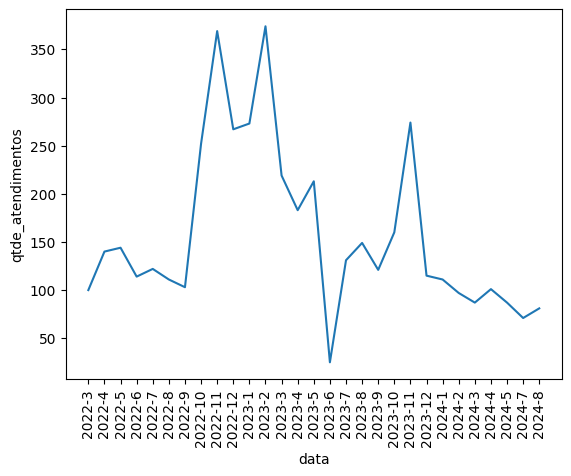

In [477]:
mask = df_merged_kpi_vendas["cpf_vendedor_inteiro"] == "00624423506"
plt.xticks(rotation=90)
sns.lineplot(data=df_merged_kpi_vendas[mask], x="data", y="qtde_atendimentos")